In [1]:
# --- INSTALLS & IMPORTS ---
!pip install -q xgboost==2.1.1
# Ensure other libraries are present
!pip install -q scikit-learn==1.5.2 nltk==3.9.1

import os, re, string, pickle, math, warnings
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm import tqdm

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# XGBoost
import xgboost as xgb

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

for pkg in ['punkt', 'stopwords', 'wordnet', 'omw-1.4', 'punkt_tab']:
    try: nltk.data.find(f'tokenizers/{pkg}')
    except LookupError: nltk.download(pkg, quiet=True)

warnings.filterwarnings("ignore")

# --- CONFIGURATION ---
RNG = 42
N_CLASSES = 3
CSV_PATH = "/kaggle/input/composite-2-194k-xgb/Composite2_194k data.csv" 

# --- DATA LOADING ---
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"File not found at {CSV_PATH}")

df = pd.read_csv(CSV_PATH)
df = df.dropna(subset=['reviewText','target_label']).copy()
df['label'] = df['target_label'].astype(int)
df['title'] = df['title'].fillna("")
df['genre'] = df['genre'].fillna("Unknown")
df = df[df['label'].isin([0, 1, 2])].reset_index(drop=True)

print(f"Data Loaded: {len(df)} rows")

# --- TEXT PREPROCESSING (MATCHING LIGHTGBM) ---
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_text(s: str) -> str:
    if not isinstance(s, str): s = "" if pd.isna(s) else str(s)
    s = s.lower()
    s = re.sub(r"'", "'", s)
    s = re.sub(r"n't\b", " not", s)
    s = re.sub(r"'re\b", " are", s)
    s = re.sub(r"'s\b", " is", s)
    s = re.sub(r"'d\b", " would", s)
    s = re.sub(r"'ll\b", " will", s)
    s = re.sub(r"'ve\b", " have", s)
    s = re.sub(r"'m\b", " am", s)
    s = re.sub(r"http\S+|www\.\S+|[\w\.-]+@[\w\.-]+", " ", s)
    s = re.sub(r"[^a-z\s]", " ", s)
    tokens = [w for w in word_tokenize(s) if w not in STOPWORDS and len(w) > 2]
    return " ".join([stemmer.stem(lemmatizer.lemmatize(w)) for w in tokens])

print("Cleaning text columns...")
df['clean_review'] = df['reviewText'].map(clean_text)
df['clean_title']  = df['title'].map(clean_text)

# --- SPLIT ---
train_df, test_df = train_test_split(df, test_size=0.2, random_state=RNG, stratify=df['label'])
y_train = train_df['label'].values
y_test  = test_df['label'].values

# --- FEATURE ENGINEERING ---

# 1. TF-IDF
def get_tfidf(train_text, test_text, max_features=60000):
    vec = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_features=max_features, dtype=np.float32)
    X_tr = vec.fit_transform(train_text)
    X_te = vec.transform(test_text)
    return X_tr, X_te

# 2. Directors (Frequency + Target Mean)
def get_director_features(train_df, test_df, y_train):
    s_train = train_df['director_encoded'].fillna("Unknown").astype(str)
    s_test  = test_df['director_encoded'].fillna("Unknown").astype(str)
    
    # Frequency
    freq = s_train.value_counts()
    tr_freq = np.log1p(s_train.map(freq).fillna(0).values)[:, None]
    te_freq = np.log1p(s_test.map(freq).fillna(0).values)[:, None]
    
    # Target Encoding (Multiclass)
    y_ohe = OneHotEncoder(sparse_output=False).fit_transform(y_train.reshape(-1,1))
    global_mean = y_ohe.mean(axis=0)
    tr_te = np.zeros((len(train_df), 3), dtype=np.float32)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)
    for tr_i, val_i in skf.split(s_train, y_train):
        X_fold = s_train.iloc[tr_i]
        means = pd.DataFrame(y_ohe[tr_i]).groupby(X_fold).mean()
        tr_te[val_i] = s_train.iloc[val_i].map(lambda x: means.loc[x].values if x in means.index else global_mean).tolist()
        
    final_means = pd.DataFrame(y_ohe).groupby(s_train).mean()
    te_te = s_test.map(lambda x: final_means.loc[x].values if x in final_means.index else global_mean).tolist()
    
    return np.hstack([tr_freq, tr_te]), np.hstack([te_freq, np.array(te_te)])

# 3. Other (Num, Genre, Lang)
def get_other_features(train_df, test_df):
    # Numerics
    cols = ['tomatoMeter', 'audienceScore', 'runtimeMinutes']
    scaler = StandardScaler()
    X_tr_num = scaler.fit_transform(train_df[cols].fillna(train_df[cols].median()))
    X_te_num = scaler.transform(test_df[cols].fillna(test_df[cols].median()))
    
    # Genre
    mlb = MultiLabelBinarizer()
    tr_gen = train_df['genre'].str.split(', ')
    te_gen = test_df['genre'].str.split(', ')
    X_tr_gen = mlb.fit_transform(tr_gen)
    X_te_gen = mlb.transform(te_gen)
    
    # Language
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
    tr_lan = train_df[['language_encoded']].fillna(-1).astype(str)
    te_lan = test_df[['language_encoded']].fillna(-1).astype(str)
    X_tr_lan = ohe.fit_transform(tr_lan)
    X_te_lan = ohe.transform(te_lan)
    
    return sparse.hstack([X_tr_num, X_tr_gen, X_tr_lan]), sparse.hstack([X_te_num, X_te_gen, X_te_lan])

# --- BUILD MATRICES ---
print("Building Matrices...")
Xtr_review, Xte_review = get_tfidf(train_df['clean_review'], test_df['clean_review'], 60000)
Xtr_title,  Xte_title  = get_tfidf(train_df['clean_title'],  test_df['clean_title'],  30000)
Xtr_dir,    Xte_dir    = get_director_features(train_df, test_df, y_train)
Xtr_oth,    Xte_oth    = get_other_features(train_df, test_df)

# Specifics for Top 4 (Review, Title, Genre, TomatoMeter)
# We need to isolate Genre and TomatoMeter specifically
scaler_tm = StandardScaler()
tm_med = train_df['tomatoMeter'].median()
Xtr_tm = scaler_tm.fit_transform(train_df[['tomatoMeter']].fillna(tm_med))
Xte_tm = scaler_tm.transform(test_df[['tomatoMeter']].fillna(tm_med))

mlb_gen = MultiLabelBinarizer()
Xtr_gen = mlb_gen.fit_transform(train_df['genre'].str.split(', '))
Xte_gen = mlb_gen.transform(test_df['genre'].str.split(', '))

print("Preprocessing Complete.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 11.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 114.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 69.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.
Data Loaded: 194784 rows
Cleaning text columns...
Building Matrices...
Preprocessing Complete.



XGBOOST — ALL FEATURES (Multiclass)
Constructing Feature Matrix (Stacking)...
Final Train Shape: (155827, 83942)
Final Test Shape:  (38957, 83942)
Creating XGBoost DMatrix...

Running 5-Fold Cross-Validation...
  Fold 1: acc=0.6250 | f1=0.6207
  Fold 2: acc=0.6234 | f1=0.6194
  Fold 3: acc=0.6264 | f1=0.6229
  Fold 4: acc=0.6195 | f1=0.6158
  Fold 5: acc=0.6247 | f1=0.6213
  CV mean: acc=0.6238  f1=0.6200

Training on full training set...
[0]	train-mlogloss:1.08808	test-mlogloss:1.08831
[100]	train-mlogloss:0.85351	test-mlogloss:0.86088
[200]	train-mlogloss:0.82799	test-mlogloss:0.83973
[300]	train-mlogloss:0.81323	test-mlogloss:0.82875
[400]	train-mlogloss:0.80173	test-mlogloss:0.82081
[500]	train-mlogloss:0.79190	test-mlogloss:0.81433
[600]	train-mlogloss:0.78351	test-mlogloss:0.80909
[700]	train-mlogloss:0.77616	test-mlogloss:0.80474
[800]	train-mlogloss:0.76946	test-mlogloss:0.80080
[900]	train-mlogloss:0.76334	test-mlogloss:0.79734
[1000]	train-mlogloss:0.75780	test-mlogloss:0.79

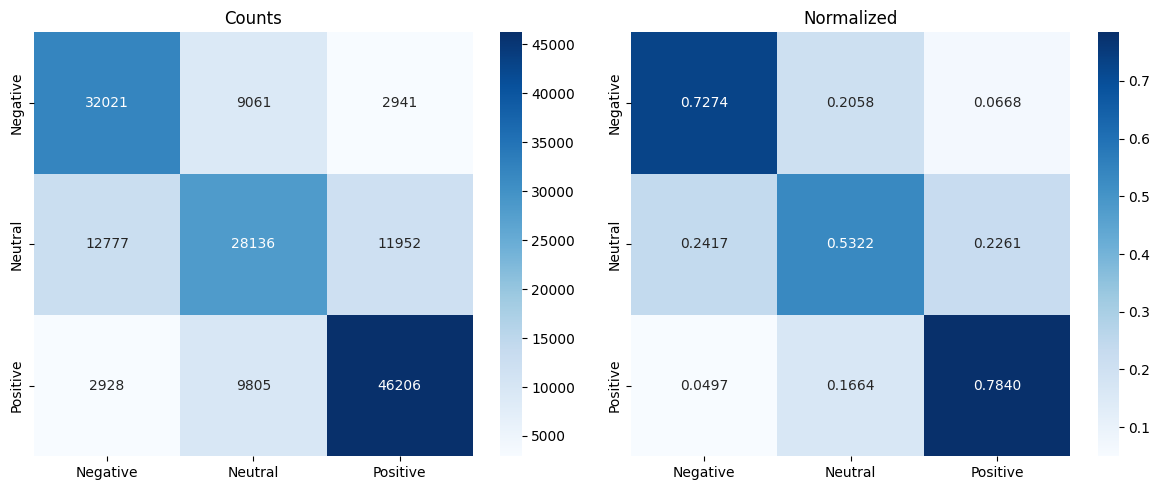


[ALL_FEATURES_TEST | XGBoost]
Accuracy=0.6341  F1_weighted=0.6307

--- Classification Report ---
              precision    recall  f1-score   support

    Negative     0.6230    0.6770    0.6489     11006
     Neutral     0.5217    0.4667    0.4927     13216
    Positive     0.7303    0.7521    0.7410     14735

    accuracy                         0.6341     38957
   macro avg     0.6250    0.6319    0.6275     38957
weighted avg     0.6292    0.6341    0.6307     38957



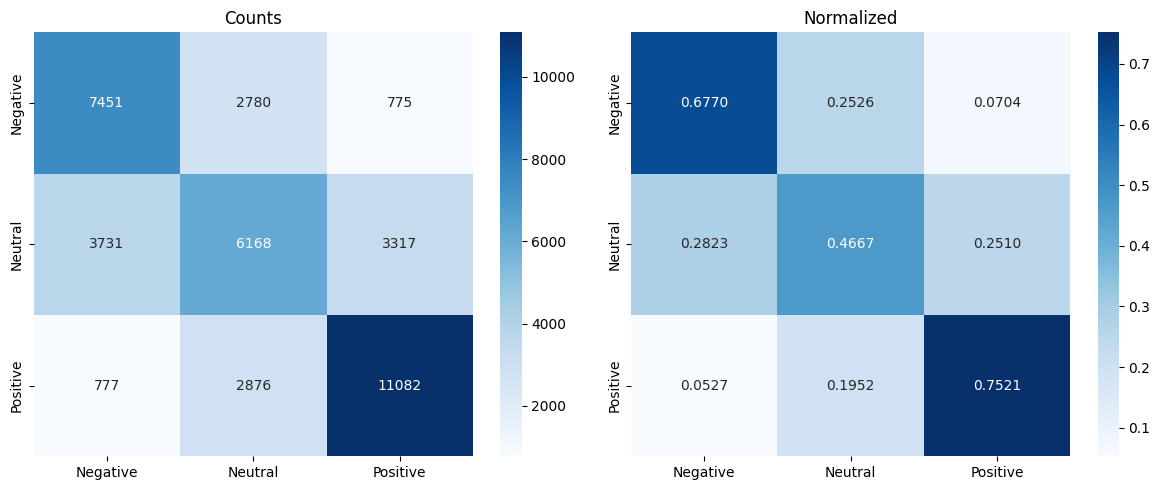


✅ Model saved to: /kaggle/working/XGBoost_Multiclass/ALL_FEATURES/XGBoost_ALL_Multiclass.pkl


In [9]:
# ======================================================================
# XGBOOST — ALL FEATURES (Final Corrected)
# ======================================================================
import xgboost as xgb
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold

# --- 1. SETUP PATHS ---
BASE_SAVE_DIR = "/kaggle/working/XGBoost_Multiclass"
setup = "ALL_FEATURES"
save_dir = os.path.join(BASE_SAVE_DIR, setup)
os.makedirs(save_dir, exist_ok=True)

print(f"\n{'='*70}")
print(f"XGBOOST — ALL FEATURES (Multiclass)")
print(f"{'='*70}")

# --- 2. DEFINE X_train_ALL (FIXED: Added .tocsr()) ---
print("Constructing Feature Matrix (Stacking)...")
# The .tocsr() call converts the matrix to a format that supports slicing [rows]
X_train_ALL = sparse.hstack([Xtr_review, Xtr_title, Xtr_oth, sparse.csr_matrix(Xtr_dir)]).tocsr()
X_test_ALL  = sparse.hstack([Xte_review, Xte_title, Xte_oth, sparse.csr_matrix(Xte_dir)]).tocsr()

print(f"Final Train Shape: {X_train_ALL.shape}")
print(f"Final Test Shape:  {X_test_ALL.shape}")

# --- 3. EVALUATION FUNCTION ---
def evaluate_and_plot(model_name, setup_name, y_true, y_prob, y_pred, save_dir, class_names=['Negative', 'Neutral', 'Positive']):
    os.makedirs(save_dir, exist_ok=True)
    n_classes = len(class_names)
    acc = accuracy_score(y_true, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"\n[{setup_name} | {model_name}]")
    print(f"Accuracy={acc:.4f}  F1_weighted={f1:.4f}")
    print("\n--- Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(n_classes))
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Counts')
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_norm, annot=True, fmt='.4f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'{model_name}_{setup_name}_confusion.png'))
    plt.show()

# --- 4. CREATE DMATRIX ---
print("Creating XGBoost DMatrix...")
class_weights = compute_class_weight('balanced', classes=np.array([0,1,2]), y=y_train)
weights_map = {i: w for i, w in enumerate(class_weights)}
sample_weights_train = np.array([weights_map[y] for y in y_train])

dtrain_all = xgb.DMatrix(X_train_ALL, label=y_train, weight=sample_weights_train)
dtest_all  = xgb.DMatrix(X_test_ALL, label=y_test)

# --- 5. XGBOOST PARAMS ---
xgb_params = {
    'objective': 'multi:softprob',
    'num_class': N_CLASSES,
    'eval_metric': 'mlogloss',
    'max_depth': 6,
    'learning_rate': 0.05,
    'reg_alpha': 2.0,
    'reg_lambda': 5.0,
    'min_child_weight': 10,
    'subsample': 0.7,
    'colsample_bytree': 0.6,
    'device': 'cuda',       # GPU
    'tree_method': 'hist',
    'random_state': RNG,
    'verbosity': 0
}

# --- 6. 5-FOLD CV ---
print("\nRunning 5-Fold Cross-Validation...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)
cv_scores = []

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train_ALL, y_train), 1):
    X_tr_fold = X_train_ALL[tr_idx]
    X_val_fold = X_train_ALL[val_idx]
    y_tr_fold = y_train[tr_idx]
    y_val_fold = y_train[val_idx]
    
    w_tr_fold = np.array([weights_map[y] for y in y_tr_fold])
    
    dtr_fold = xgb.DMatrix(X_tr_fold, label=y_tr_fold, weight=w_tr_fold)
    dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold)
    
    model_fold = xgb.train(
        xgb_params, dtr_fold, num_boost_round=1000,
        evals=[(dtr_fold, 'train'), (dval_fold, 'valid')],
        early_stopping_rounds=50, verbose_eval=False
    )
    
    y_pred = np.argmax(model_fold.predict(dval_fold), axis=1)
    acc = accuracy_score(y_val_fold, y_pred)
    f1 = precision_recall_fscore_support(y_val_fold, y_pred, average='weighted', zero_division=0)[2]
    cv_scores.append((acc, f1))
    print(f"  Fold {fold}: acc={acc:.4f} | f1={f1:.4f}")

cv_arr = np.array(cv_scores)
print(f"  CV mean: acc={cv_arr[:,0].mean():.4f}  f1={cv_arr[:,1].mean():.4f}")

# --- 7. FULL TRAINING ---
print("\nTraining on full training set...")
model_all = xgb.train(
    xgb_params, dtrain_all, num_boost_round=2000,
    evals=[(dtrain_all, 'train'), (dtest_all, 'test')],
    early_stopping_rounds=50, verbose_eval=100
)

# --- 8. EVALUATION ---
print("\nEvaluating...")
train_prob = model_all.predict(dtrain_all)
train_pred = np.argmax(train_prob, axis=1)
test_prob = model_all.predict(dtest_all)
test_pred = np.argmax(test_prob, axis=1)

evaluate_and_plot("XGBoost", f"{setup}_TRAIN", y_train, train_prob, train_pred, save_dir)
evaluate_and_plot("XGBoost", f"{setup}_TEST", y_test, test_prob, test_pred, save_dir)

# --- 9. SAVE ---
model_path = os.path.join(save_dir, "XGBoost_ALL_Multiclass.pkl")
with open(model_path, "wb") as f:
    pickle.dump({
        "model": model_all,
        "class_weight_dict": weights_map,
        "xgb_params": xgb_params
    }, f)

print(f"\n✅ Model saved to: {model_path}")